In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torch import optim
import time
import torch.nn.functional as  F


from Image_Sampler import Sampler

MODEL_NAME = "overfit"
PATH = "/disk/vanishing_data/is789/models/" + MODEL_NAME + "/"
IMG_TRAIN = "/disk/vanishing_data/is789/anomaly_samples/40test/"
IMG_TEST = "/disk/vanishing_data/is789/anomaly_samples/40test/"
TRAIN_ID = "7c89dda94374478a8937be5916177f70"
TEST_ID = "8ce5cdd31e8e499db2e07fc70b6136d5"
###lr anpassen auch die early stops
epoch = 10
BATCH_SIZE = 2
imgSize=512
zDim=256
learning_rate = 1e-05 #1e-04 
REDUCE_THRESHOLD = [0.6,0.8]
start_time = time.time()

In [2]:
if not os.path.isdir(PATH):
    os.mkdir(PATH)

In [3]:
print("Loading data...")
train_data = Sampler.load_Images(IMG_TRAIN).astype("float32") / 255

test_data = Sampler.load_Images(IMG_TEST).astype("float32") / 255


Loading data...
Loaded 40 images | width = 512, height = 512, channels = 3
Loaded 40 images | width = 512, height = 512, channels = 3


In [4]:
## transpose images

def discardLabels(data):
    x = 0
    new_data = []
    for img in data:
#         img = img.numpy()
        img = np.transpose(img, (2,1,0))
        new_data.append(img)
        x+=1
        if x == 40:
            return np.array(new_data)
        
    return np.array(new_data)

train_data = torch.as_tensor(discardLabels(train_data))
test_data = torch.as_tensor(discardLabels(test_data))

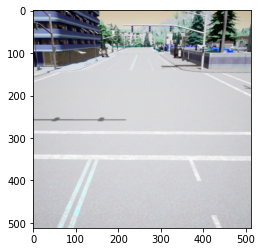

In [5]:
img = train_data[14]
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [6]:
## apply noise
noise_set = []

for img in test_data:
    pic = img.numpy().copy()
    pic[:,250:310,200:350] = 0.0
    noise_set.append(pic)

noise_set = np.array(noise_set)
noise_set = torch.as_tensor(noise_set)
noise_set.shape

torch.Size([40, 3, 512, 512])

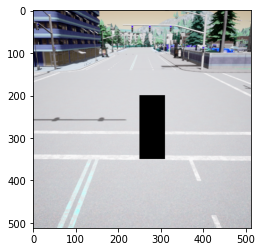

In [7]:
## show noisy image

img = noise_set[11]
# img = img.squeeze()
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [9]:

class VAE(nn.Module):
    
    def __init__(self, imgChannels=3, imgSize=imgSize, zDim=zDim):
        super(VAE, self).__init__()
        
        stride=[1,2,1,2,2,2]
        out_stride=[2,2,2,2,2,2]
#         in_stride=[1,2,2,2,2]
#         out_stride=[1,2,2,2,1]
        in_padding=[1,0,1,0,0,0]
        in_trans_padding=[0,0,0,1,1,0]
        out_padding=[0,0,0,0,0,1]
        kernel=[3,3,3,3,3,3]
#         layers=[128, 128, 128, 256, 256]
#         layers=[32, 32, 32, 32, 32, 32, 32]
        layers=[32, 32, 32, 32, 32, 32]
#         layers=[64, 128, 128, 128, 256]

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=kernel[0], stride=stride[0], padding=in_padding[0])
        self.encBn1 = nn.BatchNorm2d(layers[0])
        self.encConv2 = nn.Conv2d(in_channels=layers[0], out_channels=layers[1], kernel_size=kernel[1], stride=stride[1], padding=in_padding[1])
        self.encBn2 = nn.BatchNorm2d(layers[1])
        self.encConv3 = nn.Conv2d(in_channels=layers[1], out_channels=layers[2], kernel_size=kernel[2], stride=stride[2], padding=in_padding[2])
        self.encBn3 = nn.BatchNorm2d(layers[2])
        self.encConv4 = nn.Conv2d(in_channels=layers[2], out_channels=layers[3], kernel_size=kernel[3], stride=stride[3], padding=in_padding[3])
        self.encBn4 = nn.BatchNorm2d(layers[3])
        self.encConv5 = nn.Conv2d(in_channels=layers[3], out_channels=layers[4], kernel_size=kernel[4], stride=stride[4], padding=in_padding[4])
        self.encBn5 = nn.BatchNorm2d(layers[4])
        self.encConv6 = nn.Conv2d(in_channels=layers[4], out_channels=layers[5], kernel_size=kernel[5], stride=stride[5], padding=in_padding[5])
        self.encBn6 = nn.BatchNorm2d(layers[5])
#         self.encConv7 = nn.Conv2d(in_channels=layers[5], out_channels=layers[6], kernel_size=kernel[6], stride=stride[6], padding=in_padding[6])
#         self.encBn7 = nn.BatchNorm2d(layers[6])
        
        encoderDims = self.calcEncoderDims(len(layers), imgSize, kernel, in_padding, stride)
        featureDim = layers[-1] * encoderDims[-1] * encoderDims[-1]
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBn1 = nn.BatchNorm1d(featureDim)
#         self.decConv1 = nn.ConvTranspose2d(in_channels=layers[6], out_channels=layers[5], kernel_size=kernel[6], stride=stride[6], padding=in_trans_padding[0], output_padding=out_padding[0])
#         self.decBn2 = nn.BatchNorm2d(layers[5])
        self.decConv2 = nn.ConvTranspose2d(in_channels=layers[5], out_channels=layers[4], kernel_size=kernel[5], stride=stride[5], padding=in_trans_padding[0], output_padding=out_padding[0])
        self.decBn3 = nn.BatchNorm2d(layers[4])
        self.decConv3 = nn.ConvTranspose2d(in_channels=layers[4], out_channels=layers[3], kernel_size=kernel[4], stride=stride[4], padding=in_trans_padding[1], output_padding=out_padding[1])
        self.decBn4 = nn.BatchNorm2d(layers[3])
        self.decConv4 = nn.ConvTranspose2d(in_channels=layers[3], out_channels=layers[2], kernel_size=kernel[3], stride=stride[3], padding=in_trans_padding[2], output_padding=out_padding[2])
        self.decBn5 = nn.BatchNorm2d(layers[2])
        self.decConv5 = nn.ConvTranspose2d(in_channels=layers[2], out_channels=layers[1], kernel_size=kernel[2], stride=stride[2], padding=in_trans_padding[3], output_padding=out_padding[3])
        self.decBn6 = nn.BatchNorm2d(layers[1])
        self.decConv6 = nn.ConvTranspose2d(in_channels=layers[1], out_channels=layers[0], kernel_size=kernel[1], stride=stride[1], padding=in_trans_padding[4], output_padding=out_padding[4])
        self.decBn7 = nn.BatchNorm2d(layers[0])
        self.decConv7 = nn.ConvTranspose2d(in_channels=layers[0], out_channels=imgChannels, kernel_size=kernel[0], stride=stride[0], padding=in_trans_padding[5], output_padding=out_padding[5])
        
        self.final_encoder_dim = None
        
        decoderDims = self.calcDecoderDims(len(layers), encoderDims[-1], kernel, in_trans_padding, out_padding, stride)
        self.printModel(layers, encoderDims, decoderDims, imgSize, imgChannels)

    def calcEncoderDims(self, layer_size, imageSize, kernel, in_padding, stride):
        newDims = [imageSize]
        for x in range(layer_size):
#             tmpSize = int((newDims[-1]-kernel[x]+2*in_padding[x])/stride[x])+1
            tmpSize = int(((newDims[-1] + 2*in_padding[x]-(kernel[x]-1)-1)/stride[x])+1)
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    def calcDecoderDims(self, layer_size, imageSize, kernel, in_trans_padding, out_padding, stride, d=1):
        newDims = [imageSize]
        for x in range(layer_size):            
            tmpSize = (newDims[-1] - 1)*stride[layer_size-1-x] - 2*in_trans_padding[x] + d*(kernel[x] - 1) + out_padding[x] + 1
            newDims.append(tmpSize)
#         newDims.pop(0)
        return newDims
    
    
    def printModel(self, layers, encDims, decDims, imageSize, imgChannels):
        print("=============")
        print("Image Flow:")
        print("Encoder:")
        print(f"{imageSize}x{imageSize}x{imgChannels} (Input Image)")
        for x in range(len(layers)):
            print(f"{encDims[x]}x{encDims[x]}x{layers[x]}")
        
        print("Decoder:")
        k = len(layers) - 1
        for x in range(len(layers)):
            print(f"{decDims[x]}x{decDims[x]}x{layers[k]}")
            k = k - 1
        print(f"{decDims[-1]}x{decDims[-1]}x{imgChannels} (Output Image)")
        print("=============")
            
        
    def encoder(self, x):

        x = F.relu(self.encConv1(x))
        x = self.encBn1(x)
        x = F.relu(self.encConv2(x))
        x = self.encBn2(x)
        x = F.relu(self.encConv3(x))
        x = self.encBn3(x)
        x = F.relu(self.encConv4(x))
        x = self.encBn4(x)
        x = F.relu(self.encConv5(x))
        x = self.encBn5(x)
        x = F.relu(self.encConv6(x))
        x = self.encBn6(x)
#         x = F.relu(self.encConv7(x))
#         x = self.encBn7(x)
        self.final_encoder_dim = np.array([x.size(1), x.size(2), x.size(3)])
        flatten = np.prod(self.final_encoder_dim)

        x = x.view(-1, flatten)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.leaky_relu(self.decFC1(z))
        x = self.decBn1(x)
        x = x.view(-1, self.final_encoder_dim[0], self.final_encoder_dim[1], self.final_encoder_dim[2])
#         x = F.leaky_relu(self.decConv1(x))
#         x = self.decBn2(x)
        x = F.leaky_relu(self.decConv2(x))
        x = self.decBn3(x)
        x = F.leaky_relu(self.decConv3(x))
        x = self.decBn4(x)
        x = F.leaky_relu(self.decConv4(x))
        x = self.decBn5(x)
        x = F.leaky_relu(self.decConv5(x))
        x = self.decBn6(x)
        x = F.leaky_relu(self.decConv6(x))
        x = self.decBn7(x)
        x = torch.sigmoid(self.decConv7(x))
#         print(x.size())
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [10]:
# model = VAE()
# model.to(device)
# model.load_state_dict(torch.load(PATH))

In [11]:

def loss_fn(x, recon_x, mu, log_var):
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction = "sum")
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32
#     Recon_loss = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32 *3
#     KLD_loss = 1 + log_var - mu.pow(2) - log_var.exp()
#     KLD_loss = torch.sum(KLD_loss)
#     KLD_loss *= -0.5
#     return torch.mean(Recon_loss + KLD_loss)
#     Recon_loss = F.mse_loss(recon_x.view(-1, 2500), x.view(-1, 2500), reduction = "sum") * 32 * 32 *3
#     Recon_loss = F.binary_cross_entropy(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum") * imgSize * imgSize *3
    Recon_loss = F.mse_loss(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum")
    Recon_loss_adapted = Recon_loss * imgSize * imgSize *3
    KLD_loss = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 - log_var)
    return Recon_loss_adapted + KLD_loss, Recon_loss


In [12]:
model = VAE()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params}")

Image Flow:
Encoder:
512x512x3 (Input Image)
512x512x32
255x255x32
255x255x32
127x127x32
63x63x32
31x31x32
Decoder:
31x31x32
63x63x32
127x127x32
255x255x32
255x255x32
509x509x32
512x512x3 (Output Image)
Trainable params: 15932483


cuda


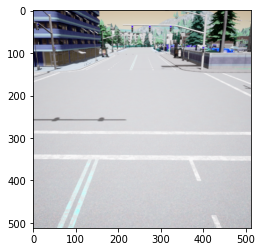

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch.utils.data import DataLoader

dataloaders = {}
dataloaders["train"] = DataLoader(dataset=train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["test"] = DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["noise"] = DataLoader(dataset=noise_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

images = next(iter(dataloaders["test"]))
plt.imshow(np.transpose(images[0], (2,1,0)))


In [14]:
def evalOnSet(data):
    avg_MSE = 0
    for x in data:
        true_img = img.numpy()
        img = np.array([true_img])
        img = torch.as_tensor(img)
        img = img.to(device)
        out, _, _ = model(img)
        out = out[0].detach().cpu().numpy()
        errorMatrix = np.absolute(true_img - out)
        errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1] * errorMatrix.shape[2])
        avg_MSE += errorAvg
    return avg_MSE / len(data)

In [15]:
len(dataloaders["train"].dataset)

40

In [16]:
train_losses = []
val_losses = []

reducer = []
for cutter in REDUCE_THRESHOLD:
    reducer.append(int(epoch * cutter))

print("Training started!")

for e in range(1, epoch+1):
    for reduce in reducer:    
        if e == reduce:
            for g in optimizer.param_groups:
                g['lr'] = learning_rate / 10
            print("Changed learningrate")

    train_loss = 0.0
    for x in dataloaders["train"]:
        x = x.to(device)
        x_recon, mu, log_var = model(x)

        optimizer.zero_grad()
        loss, mae = loss_fn(x, x_recon, mu, log_var)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    val_loss = 0.0
    for x in dataloaders["test"]:
        x = x.to(device)
        x_recon, mu, log_var = model(x)

        optimizer.zero_grad()
        loss, mae = loss_fn(x, x_recon, mu, log_var)

        val_loss += loss.item()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_loss /= len(dataloaders["train"].dataset)
    val_loss /= len(dataloaders["test"].dataset)

    print(f"Epoch {e} | Loss: {train_loss} | V_Loss: {val_loss} | MAE: {val_loss}")
    


Training started!


AttributeError: 'VAE' object has no attribute 'encFC2'

## Evaluation Section

In [ ]:
model.eval()

In [ ]:
end_time = time.time()
time_elapsed = ((end_time - start_time) / 60.0) / 60.0
time_elapsed = int(time_elapsed * 100000)/ 100000.0

avg_mse = evalOnSet(test_data)
print(avg_mse)

file = open(PATH + "summary.txt", "w")
file.write("Train loss: " + str(train_losses[-1]) + " Val loss: " + str(val_losses[-1]))
file.write("\nEpochs: " + str(epoch))
file.write("\nBatchSize: " + str(BATCH_SIZE))
file.write("\nzDim: " + str(zDim))
file.write("\nAvg mse on test_data: " + str(avg_mse))
file.write("\nTime elapsed: " + str(time_elapsed) + " hours")

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses[15:],label="val")
plt.plot(train_losses[15:],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(PATH + "loss_plot.svg")
plt.savefig(PATH + "loss_plot.png")
plt.show()

In [ ]:
def printReconError(img_in, img_out, threshold=None):
    img_in = img_in.dot([0.07, 0.72, 0.21])
    img_out = img_out.dot([0.07, 0.72, 0.21])
    errorMatrix = np.absolute(img_in - img_out)
    if not threshold == None:
        errorMatrix[errorMatrix < threshold] = 0.0
    errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1])
    print(f"MAE: {errorAvg}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Original")
    ax1.imshow(img_in, cmap="gray")
    ax2.set_title("Recreation")
    ax2.imshow(img_out, cmap="gray")
    ax3.set_title("ErrorMap")
    ax3.imshow(errorMatrix, cmap="gray")

In [ ]:
import random

# model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["train"]), 1):
        imgs = imgs.to(device)
#         plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))
#         plt.imshow(img, cmap="gray")
        
        out, mu, logVAR = model(imgs)
#         plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))
#         plt.imshow(out, cmap="gray")
        
        printReconError(img, out, 0.0)
        break

In [ ]:
import random

def make_prediction(dataSet, index):
    model.eval()
    with torch.no_grad():
        imgs = torch.as_tensor(np.array([dataSet[index].numpy()]))
        print(imgs.shape)
        imgs = imgs.to(device)
    #         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))

        out, mu, logVAR = model(imgs)
    #         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))

        #plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.set_title("Original")
        ax1.imshow(img)
        ax2.set_title("Reconstruction")
        ax2.imshow(out)
        return fig

In [ ]:
make_prediction(train_data, 0)

In [ ]:
make_prediction(test_data, 0)

In [ ]:
torch.save(model.state_dict(), PATH + "model.pt")